In [90]:
from fastai.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *

In [91]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [92]:
DATA_PATH = Path.cwd()/'data'

In [93]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2])

In [94]:
train_tl = TfmdLists(range(7500), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(512), ImageTupleTransform(ds))

In [95]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=128, drop_last=True,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [96]:
loss_func = StackLoss(MSELossFlat())

Left: Input, Right: Target

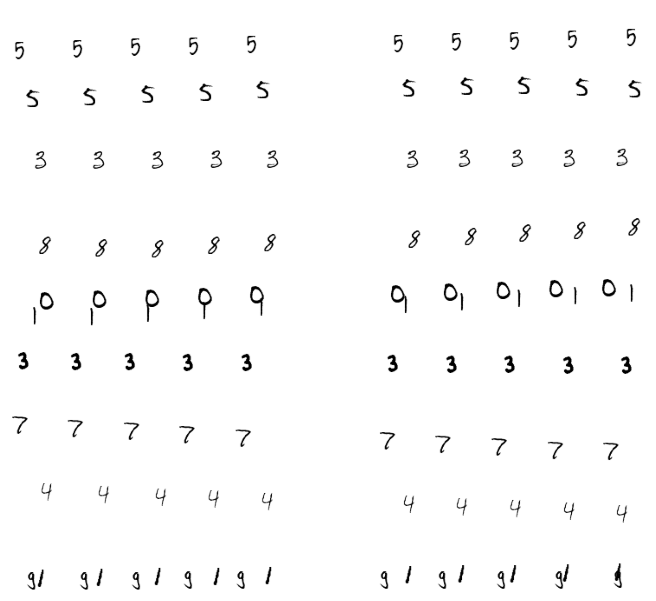

In [97]:
dls.show_batch()

In [98]:
b = dls.one_batch()
explode_types(b)

{tuple: [{moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

## Simple model

In [100]:
unet = create_unet_model(resnet18, n_out=5, n_in=5, img_size=(64,64), blur=True, self_attention=True, norm_type=NormType.Spectral)

In [115]:
class CatUnstack(Module):
    "Concatenate together inputs, apply module, unstack output"
    def __init__(self, module, dim=1):
        self.dim = dim
        self.module = module

    @staticmethod
    def unbind_images(x, dim=1): return _unbind_images(x, dim)
    def forward(self, *args):
        inputs = torch.cat(*args, dim=self.dim)
        outputs = self.module(inputs)
        if isinstance(outputs, (tuple, list)):
            return [self.unbind_images(output, dim=self.dim) for output in outputs]
        else: return outputs.unsqueeze(2).unbind(dim=self.dim)

In [116]:
model = CatUnstack(unet).cuda()

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [117]:
learn = Learner(dls, model, loss_func=loss_func, cbs=[]).to_fp16()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

In [118]:
x,y = dls.one_batch()

In [119]:
x[0].shape

torch.Size([128, 1, 64, 64])

In [120]:
model(x)[0].shape

torch.Size([128, 1, 64, 64])

SuggestedLRs(valley=tensor(0.0012))

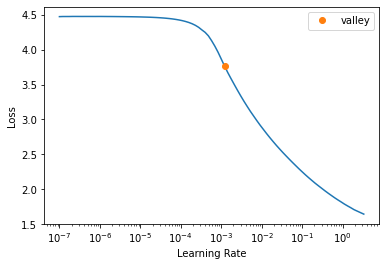

In [121]:
learn.lr_find()

In [177]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,time
0,0.440120,0.451610,00:07
1,0.440582,0.433893,00:07
2,0.435537,0.431946,00:07
3,0.436785,0.438318,00:07
4,0.436923,0.415947,00:07
5,0.433293,0.431198,00:07
6,0.433006,0.435105,00:07
7,0.431587,0.418020,00:07
8,0.433059,0.426789,00:07
9,0.430567,0.432842,00:07


In [178]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [179]:
len(p), p[0].shape

(5, torch.Size([512, 1, 64, 64]))

In [180]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

In [181]:
t[0].shape

torch.Size([512, 1, 64, 64])

In [182]:
p[0].shape

torch.Size([512, 1, 64, 64])

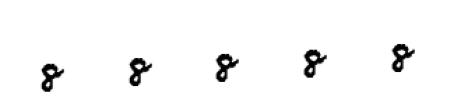

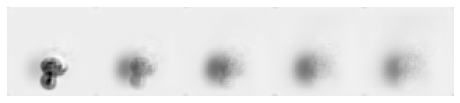

In [183]:
import random
k = random.randint(0,100)
show_res(t,k)
show_res([TensorImageBW(p_i) for p_i in p],k)